In [ ]:
from google.colab import drive
import numpy as np
import os
import cv2
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Check if the directory is empty. If it isn't list the contents so the user can diagnose.
if os.path.exists('/content/drive') and os.listdir('/content/drive'):
  print("The /content/drive directory is not empty and contains the following files:")
  for item in os.listdir('/content/drive'):
    print(item)
else:
  # If the directory is empty or doesn't exist, proceed with mounting.
  drive.mount('/content/drive')

The /content/drive directory is not empty and contains the following files:
.shortcut-targets-by-id
MyDrive
Shareddrives
.file-revisions-by-id
.Trash-0
.Encrypted


In [ ]:
!cp "/content/drive/MyDrive/extracted_nailss.zip" "/content/"

In [ ]:
!unzip -n "/content/drive/MyDrive/extracted_nailss.zip"

Archive:  /content/drive/MyDrive/extracted_nailss.zip
   creating: extracted_nailss/
  inflating: extracted_nailss/25_non_anemic_nail_2.jpg  
  inflating: extracted_nailss/125_non_anemic_nail_1.jpg  
  inflating: extracted_nailss/153_non_anemic_nail_1.jpg  
  inflating: extracted_nailss/280_anemic_nail_0.jpg  
  inflating: extracted_nailss/147_non_anemic_nail_0.jpg  
  inflating: extracted_nailss/212_non_anemic_nail_1.jpg  
  inflating: extracted_nailss/221_non_anemic_nail_0.jpg  
  inflating: extracted_nailss/19_non_anemic_nail_0.jpg  
  inflating: extracted_nailss/311_anemic_nail_2.jpg  
  inflating: extracted_nailss/249_anemic_nail_0.jpg  
  inflating: extracted_nailss/136_non_anemic_nail_0.jpg  
  inflating: extracted_nailss/128_non_anemic_nail_0.jpg  
  inflating: extracted_nailss/5_anemic_nail_1.jpg  
  inflating: extracted_nailss/82_anemic_nail_1.jpg  
  inflating: extracted_nailss/1_non_anemic_nail_0.jpg  
  inflating: extracted_nailss/100_non_anemic_nail_2.jpg  
  inflating: e

#Augmentation

In [ ]:
# Define medically-safe augmenter
augmenter = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='reflect'
)

def ensure_directory_exists(path):
    os.makedirs(path, exist_ok=True)

def load_all_images(folder_path):
    """Load all image paths from a folder"""
    image_paths = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            image_paths.append(os.path.join(folder_path, filename))
    return image_paths

def augment_images(image_paths, augmenter, target_total, output_dir):
    ensure_directory_exists(output_dir)

    original_count = len(image_paths)
    print(f"Original count: {original_count}")

    # Save original images
    for i, path in enumerate(image_paths):
        new_path = os.path.join(output_dir, f"orig_{i}_{os.path.basename(path)}")
        shutil.copy(path, new_path)

    print(f"Final count: {len(os.listdir(output_dir))}")

# Run the augmentation
image_paths = load_all_images('/content/extracted_nailss')
target_total = 750
output_dir = '/content/augmented_balanced_all'
augment_images(image_paths, augmenter, target_total, output_dir)

Original count: 750
Final count: 750


# Feature Extraction (AutoEncoder)

In [ ]:
#Load and preprocess the dataset
def load_and_preprocess_images(folder_path, target_size=(224, 224)):
    images = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Load image
            img = cv2.imread(os.path.join(folder_path, filename))
            if img is not None:
                # Resize and normalize
                img = cv2.resize(img, target_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = img.astype('float32') / 255.0
                images.append(img)

    return np.array(images)

# Load the dataset
X = load_and_preprocess_images('/content/augmented_balanced_all')

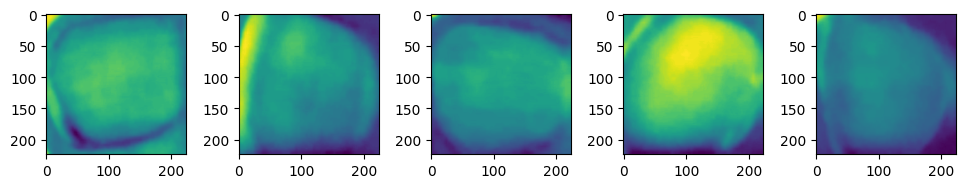

(224, 224)

In [ ]:
plt.figure(figsize=(12,4))
for i in range(5):
    # Original
    plt.subplot(2,5,i+1)
    plt.imshow(X[i])

plt.show()
X[i].shape

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - loss: 0.0276 - val_loss: 0.0079
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.0073 - val_loss: 0.0056
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 9/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 10/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 11/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 12/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/st

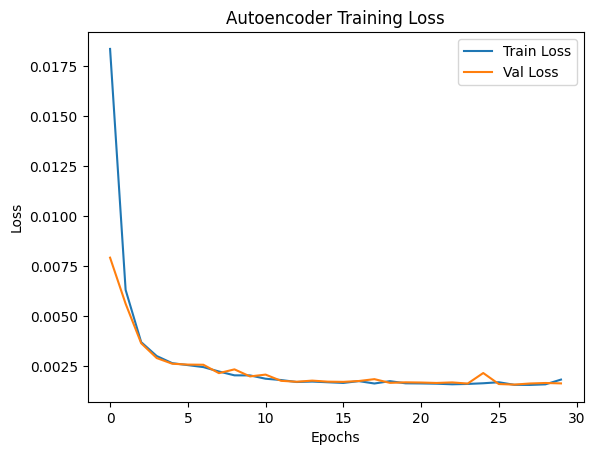

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Train-validation split
X_train, X_val = train_test_split(X, test_size=0.1, random_state=42)

# Autoencoder model for grayscale images
def build_autoencoder(input_shape=(224, 224, 1)):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 112x112x64
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 56x56x128
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 28x28x256

    shape_before_flatten = x.shape[1:]
    x = Flatten()(x)
    encoded = Dense(128, activation='relu')(x)  # Bottleneck

    # Decoder
    x = Dense(np.prod(shape_before_flatten), activation='relu')(encoded)
    x = Reshape(shape_before_flatten)(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # 1 channel output

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(0.001), loss='mse')

    encoder = Model(input_img, encoded)
    return autoencoder, encoder

# Build and train model
autoencoder, encoder = build_autoencoder()
history = autoencoder.fit(
    X_train, X_train,
    epochs=30,
    batch_size=16,
    shuffle=True,
    validation_data=(X_val, X_val)
)

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Autoencoder Training Loss")
plt.show()

# Feature extraction
def extract_features(encoder, images):
    features = encoder.predict(images)
    return features

features = extract_features(encoder, X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


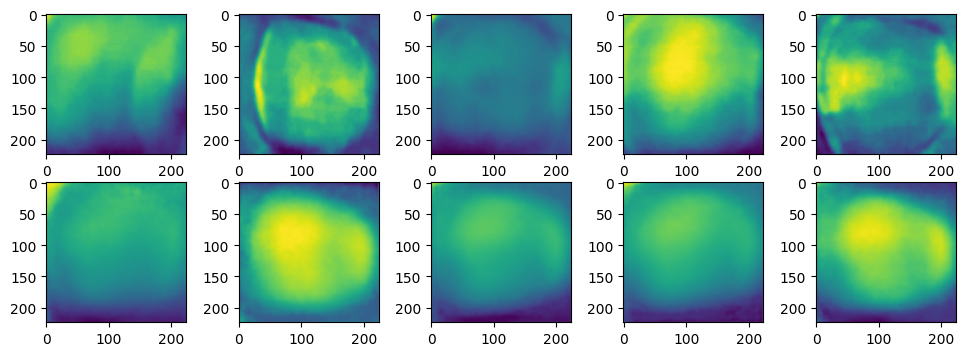

In [ ]:
# Visualize some reconstructions
decoded_imgs = autoencoder.predict(X_val[:5])

plt.figure(figsize=(12,4))
for i in range(5):
    # Original
    plt.subplot(2,5,i+1)
    plt.imshow(X_val[i])
    # Reconstruction
    plt.subplot(2,5,i+6)
    plt.imshow(decoded_imgs[i])
plt.show()

#K-means Clustering

In [ ]:
features = extract_features(encoder, X)

# Standardize and reduce dimensionality
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA(n_components=50)
features_pca = pca.fit_transform(features_scaled)

# KMeans clustering
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=20, max_iter=500, random_state=42)
labels = kmeans.fit_predict(features_pca)

# Evaluation
sil_score = silhouette_score(features_pca, labels)
print(f"Silhouette Score: {sil_score:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Silhouette Score: 0.8857


In [ ]:
print(f"Cluster Labels: \n{labels}")

Cluster Labels: 
[1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0
 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 0
 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0
 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1
 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1
 1 0 1 0 1 0 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1
 0 1 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 0
 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0
 1 0 1 0

In [ ]:
import os
import csv
from glob import glob

image_folder = '/content/augmented_balanced_all'
image_paths = sorted(glob(os.path.join(image_folder, '*')))  # includes full path

# Extract just the filenames
image_names = [os.path.basename(path) for path in image_paths]

# Output CSV file
output_file = 'image_cluster_labels.csv'

# Write to CSV
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Name', 'Cluster Label'])  # header
    for name, label in zip(image_names, labels):
        writer.writerow([name, label])

print(f"Saved labels for {len(labels)} images to '{output_file}'")


Saved labels for 750 images to 'image_cluster_labels.csv'


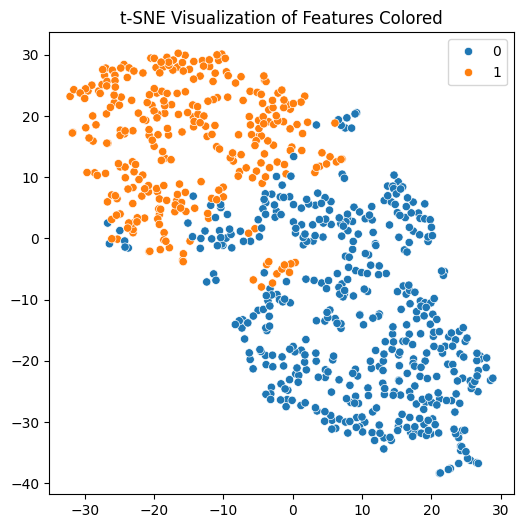

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(features_pca)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels)
plt.title("t-SNE Visualization of Features Colored")
plt.show()

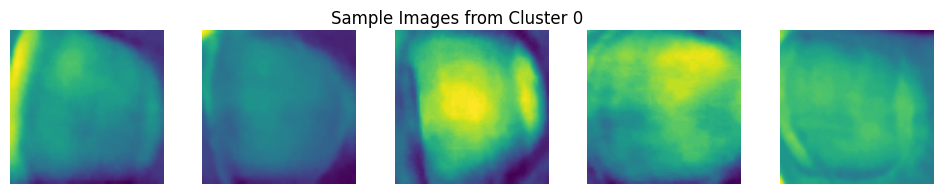

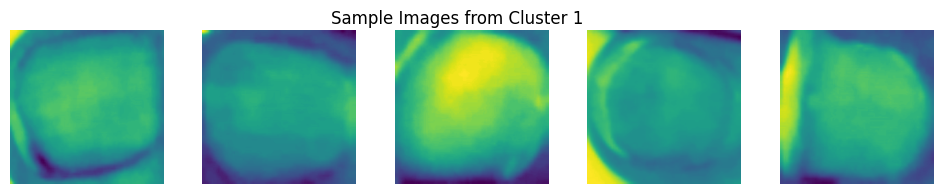

In [ ]:
#Showing samples of each cluster
def show_samples(images, labels, cluster, num_samples=5):
    indexes = np.where(labels == cluster)[0][:num_samples]
    plt.figure(figsize=(12,2))
    for i, index in enumerate(indexes):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[index])
        plt.axis('off')
    plt.suptitle(f'Sample Images from Cluster {cluster}')
    plt.show()

for cluster in range(2):
    show_samples(X, labels, cluster)

Cluster 0: 455 images
Cluster 1: 295 images


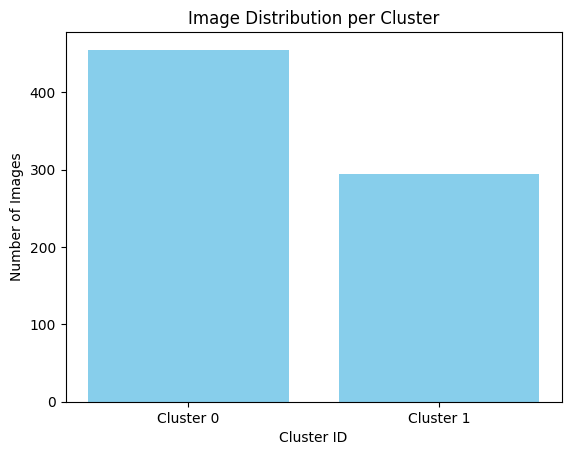

In [ ]:
# Count images in each cluster
unique, counts = np.unique(labels, return_counts=True)

# Print counts
for cluster_id, count in zip(unique, counts):
    print(f"Cluster {cluster_id}: {count} images")

# Optional: visualize as a bar chart
plt.bar(unique, counts, tick_label=[f"Cluster {i}" for i in unique], color='skyblue')
plt.title("Image Distribution per Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Images")
plt.show()